First attempt of graph network. Running on CPU.

In [1]:
import numpy as np
import itertools
import os, sys
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional  as F

In [3]:
from progressBar import ProgressBar

## Get the dataset

In [4]:
from torch.utils import data

In [5]:
class Dataset(data.Dataset):
    def __init__(self, names = 'SM', 
                 template='../data/20190624_5part_PtOrder/{}_lepFilter_13TeV.npy'):
        if names == 'SM':
            self.SM_names = ['Wlnu', 'qcd', 'ttbar', 'Zll']
            names = self.SM_names
        self.names = names
        
        for i, n in enumerate(names):
            ins = np.load(template.format(n)).astype(np.float32)
            out = i*np.ones(ins.shape[0]).astype(np.int8)
            
            print(n, ':', str(ins.shape[0]))
            
            if i == 0:
                self.inputs = ins
                self.outputs = out
            else:
                self.inputs = np.concatenate((self.inputs, ins))
                self.outputs = np.concatenate((self.outputs, out))
    
    def __len__(self):
        return self.inputs.shape[0]
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

In [6]:
dataset = {}
# Use to do validation split
# torch.utils.data.random_split(dataset, lengths)
dataset['train'] = Dataset(['Wlnu', 'Zll'])

Wlnu : 50000
Zll : 50000


## Define the model

In [7]:
class ClfGraphNet(nn.Module):
    def __init__(self, N_nodes, N_features, dim_hidden, De, Do, dim_output, verbose = False):
        super(ClfGraphNet, self).__init__()
        self.verbose = verbose
        
        self.p = N_features
        self.No = N_nodes
        self.De = De
        self.Do = Do
        
        self.Rr, self.Rs = self.buildEdgesMatrixes()
        self.fr = self.build_fr(dim_hidden)
        self.fo = self.build_fo(dim_hidden)
        self.PhiC = self.build_PhiC(dim_output)
        
        self.onGPU = False
        
        
    def buildEdgesMatrixes(self):
        ### Assume fully connected graph
        Ne = self.No * (self.No - 1)
        self.Ne = Ne
        Rr = torch.zeros(self.No, Ne)
        Rs = torch.zeros(self.No, Ne)
        receiver_sender_list = [i for i in itertools.product(range(self.No), range(self.No)) if i[0]!=i[1]]
        for i, (r, s) in enumerate(receiver_sender_list):
            Rr[r, i] = 1
            Rs[s, i] = 1
        return Rr, Rs
            
    def build_fr(self, dim_hidden):
        fr = nn.Sequential(
                            nn.Linear(2 * self.p, dim_hidden),
                            nn.ReLU(),
                            nn.Linear(dim_hidden, int(dim_hidden/2)),
                            nn.ReLU(),
                            nn.Linear(int(dim_hidden/2), self.De),
                            nn.ReLU(),
                          )
        return fr
        
    def build_fo(self, dim_hidden):
        fo = nn.Sequential(
                            nn.Linear(self.p + self.De, dim_hidden),
                            nn.ReLU(),
                            nn.Linear(dim_hidden, int(dim_hidden/2)),
                            nn.ReLU(),
                            nn.Linear(int(dim_hidden/2), self.Do),
                            nn.ReLU(),
                          )    
        return fo

    def build_PhiC(self, dim_output):
        PhiC = nn.Sequential(
                              nn.Linear(self.Do, int(0.5*(dim_output+self.Do))),
                              nn.ReLU(),
                              nn.Linear(int(0.5*(dim_output+self.Do)), dim_output),
                              nn.Sigmoid()
                            )        
        return PhiC
         
    def INlayer(self, x):
        x = torch.transpose(x, 1, 2).contiguous()
        Orr = torch.matmul(x, self.Rr)
        Ors = torch.matmul(x, self.Rs)
        B = torch.cat([Orr, Ors], dim=1)
        
        ### First MLP ###
        E = self.fr(B.view(-1, 2 * self.p))
        del B
        
        E = E.view(-1, self.Ne, self.De)
        E = torch.transpose(E, 1, 2).contiguous()
        Ebar = torch.matmul(E, torch.transpose(self.Rr, 0, 1).contiguous())
        del E
        
        C = torch.cat([x, Ebar], 1)
        del Ebar
        
        C = torch.transpose(C, 1, 2).contiguous()
        O = self.fo(C.view(-1, self.p + self.De))
        del C
        O = torch.relu(O.view(-1, self.No, self.Do))
        return O
        
    def forward(self, x):
        O = self.INlayer(x)
        
        # now sum over No nodes to obtain the Do latent quantities
        O = torch.sum(O, 1)
        y = self.PhiC(O)
        return y
    
    def useGPU(self):
        if torch.cuda.is_available():
            print('Current device: {} ({} available)'.format(torch.cuda.current_device(), 
                                                             torch.cuda.device_count()))
            
            for o in self.__dict__.values():
                if o.__class__ == torch.Tensor:
                    o.cuda()
            
            self.onGPU = True
        else: 
            print('GPU not available')
            

In [8]:
def weights_init(M):
    if hasattr(M, 'weight'):
        nn.init.xavier_normal_(M.weight.data)

In [9]:
model = ClfGraphNet(N_nodes=dataset['train'].inputs.shape[1],
                    N_features=dataset['train'].inputs.shape[2],
                    dim_hidden=30,
                    De=5,
                    Do=10,
                    dim_output=1
#                     dim_output=len(dataset['train'].names)
                   )
print(model)
trainablePars = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('\nTrainable parameters:', trainablePars)

# Initialize weights
model.apply(weights_init);

ClfGraphNet(
  (fr): Sequential(
    (0): Linear(in_features=10, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=5, bias=True)
    (5): ReLU()
  )
  (fo): Sequential(
    (0): Linear(in_features=10, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=10, bias=True)
    (5): ReLU()
  )
  (PhiC): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

Trainable parameters: 1891


[0.398366   0.3872427  0.40685657 ... 0.38186017 0.36862049 0.33193466]
0.3814658
0.038356517


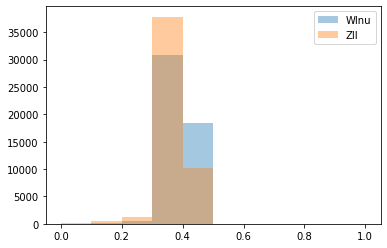

In [10]:
y_pred = model(torch.Tensor(dataset['train'].inputs)).cpu().detach().numpy().flatten()
print(y_pred)

# plt.hist(y_pred, range=(0,1))
for i in range(len(dataset['train'].names)):
    plt.hist(y_pred[dataset['train'].outputs==i], range=(0,1), label=dataset['train'].names[i], alpha=0.4)

print(np.mean(y_pred))
print(np.std(y_pred))
plt.legend(loc='best')

## Loss

In [11]:
criterion = nn.BCELoss()

## Training

In [12]:
training_params = {'batch_size': 128,
                   'shuffle': True,
                   'num_workers': 0
                  }

max_epochs = 15

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              threshold=1e-4,
                              cooldown=2
                             )

In [14]:
optimizer.zero_grad()
data_train_iter = data.DataLoader(dataset['train'], **training_params)

train_loss = []
for epoch in range(1, max_epochs+1):
    batch_loss = []
    pb = ProgressBar(len(data_train_iter), percentPrecision=5, headLabel='Ep {} '.format(epoch))
    for local_x, local_y in data_train_iter:
        if model.onGPU:
            local_x = local_x.cuda()
            local_y = local_y.cuda()
        
        y_pred = model(local_x)
        loss = criterion(y_pred.view(-1), local_y.float())
        batch_loss.append(loss.item())
        
        tail_label = 'Loss: {:2.2e}'.format(loss.item())
        if len(train_loss) > 0:
            tail_label += ' ({:2.2e})'.format(loss.item() - train_loss[-1][-1])
        pb.show(len(batch_loss)-1, tail_label=tail_label)
        loss.backward()
        optimizer.step()
        
    scheduler.step(batch_loss[-1])
    printout = 'Loss: {:2.2e}'.format(batch_loss[-1])
    if len(train_loss) > 0:
        printout += ' - Delta: {:2.2e}'.format(batch_loss[-1] - train_loss[-1][-1])
    if len(train_loss) > 1:
        d2L_de2 = batch_loss[-1] - 2*train_loss[-1][-1] + train_loss[-2][-1]
        printout +=' - Trend: {:2.2e}'.format(d2L_de2)
    print(printout+'\n')
    train_loss.append(batch_loss)
    
train_loss = np.array(train_loss)

Ep 1 [####################]  100% - Tot. time: 3.1 s            
Loss: 3.79e-01

Ep 2 [####################]  100% - Tot. time: 3.1 s                       
Loss: 3.88e-01 - Delta: 8.34e-03

Ep 3 [####################]  100% - Tot. time: 3.0 s                        
Loss: 5.01e-01 - Delta: 1.13e-01 - Trend: 1.05e-01

Ep 4 [####################]  100% - Tot. time: 3.1 s                        
Loss: 3.58e-01 - Delta: -1.43e-01 - Trend: -2.56e-01

Ep 5 [####################]  100% - Tot. time: 3.2 s                        
Loss: 3.52e-01 - Delta: -6.01e-03 - Trend: 1.37e-01

Ep 6 [####################]  100% - Tot. time: 3.2 s                        
Loss: 1.62e-01 - Delta: -1.90e-01 - Trend: -1.84e-01

Ep 7 [####################]  100% - Tot. time: 3.1 s                       
Loss: 3.09e-01 - Delta: 1.48e-01 - Trend: 3.38e-01

Ep 8 [####################]  100% - Tot. time: 3.1 s                        
Loss: 4.92e-01 - Delta: 1.83e-01 - Trend: 3.52e-02

Ep 9 [####################]  10

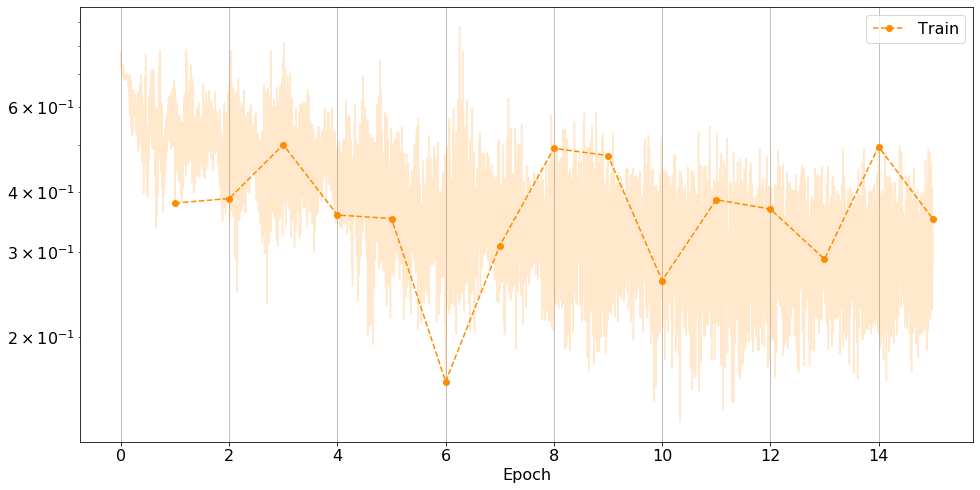

In [15]:
matplotlib.rcParams.update({'font.size': 16})

f = plt.figure(figsize=(16,8))

train_loss_flat = train_loss.flatten()
x = np.arange(1, train_loss_flat.shape[0]+1) * float(train_loss.shape[0])/train_loss_flat.shape[0]
plt.plot(x, train_loss_flat, '-', alpha=0.2, color='darkorange')

x = np.arange(1, train_loss.shape[0]+1)
plt.plot(x, train_loss[:,-1], 'o--', label='Train', color='darkorange')

plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='best')
plt.yscale('log')
# f.savefig('plots/TrainingHistory_VAE_all-in-one_v'+VAEversion+'.png')

# f = open('TrainingHistory_VAE_all-in-one_v'+VAEversion+'.pkl', 'w')
# pickle.dump(fit_report.history, f, pickle.HIGHEST_PROTOCOL)
# f.close()

[0.06520278 0.19697662 0.07334874 ... 0.8583262  0.9955486  0.4216682 ]
0.4907307
0.40601823


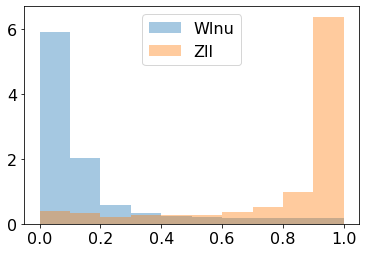

In [16]:
y_pred = model(torch.Tensor(dataset['train'].inputs)).cpu().detach().numpy().flatten()
print(y_pred)

for i in range(len(dataset['train'].names)):
    plt.hist(y_pred[dataset['train'].outputs==i], range=(0,1), label=dataset['train'].names[i], alpha=0.4, density=True)

print(np.mean(y_pred))
print(np.std(y_pred))
plt.legend(loc='best')